# Metropolis-Hastings MCMC for non-flat ΛCDM (DESI+CMB, Multiple Chains, Omega_Lambda parameterization)

This notebook estimates cosmological parameters for a non-flat ΛCDM model using DESI+CMB data, running $n_{\rm MH}$ independent Metropolis-Hastings MCMC chains with random, evenly distributed starting points in the parameter space $(H_0, \Omega_m, \Omega_\Lambda)$. Results are aggregated and compared with the literature ([arXiv:2411.12020v1](https://arxiv.org/abs/2411.12020v1)).

## Imports and Setup

In [9]:
import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

## Data Loading (DESI + CMB)

In [10]:
# DESI data
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

# CMB means and covariance (Planck, as in previous notebooks)
theta_star_mean = 1.04097/100
w_b_mean = 0.02223
w_bc_mean = 0.14208
Neff = 3.046
cmb_means = np.array([theta_star_mean, w_b_mean, w_bc_mean])
cmb_cov = np.array([
    [0.006621e-9, 0.12444e-9, -1.1929e-9],
    [0.12444e-9, 21.344e-9, -94.001e-9],
    [-1.1929e-9, -94.001e-9, 1488.4e-9]
])
cmb_cov_inv = np.linalg.inv(cmb_cov)

def r_d(w_b, w_bc, Neff=3.046):
    return 147.05 * (w_b/0.02236)**(-0.13) * (w_bc/0.1432)**(-0.23) * (Neff/3.046)**(-0.1)

r_d_val = r_d(w_b_mean, w_bc_mean, Neff)

## Log-Likelihood for non-flat ΛCDM (Omega_Lambda parameterization)

In [11]:
def model_cmb_params(H0):
    return np.array([theta_star_mean, w_b_mean, w_bc_mean])

def log_likelihood(params):
    H0, Omega_m, Omega_Lambda = params
    # Physical priors
    if not (50 < H0 < 80 and 0 < Omega_m < 1 and 0 < Omega_Lambda < 1):
        return -np.inf
    Omega_k = 1.0 - Omega_m - Omega_Lambda
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation=0.0)
    D_V_model = np.array([CosmologicalDistances(model.H).volume_distance(z_i) for z_i in z])
    chi2_desi = np.sum(((D_V_obs - D_V_model / r_d_val) / D_V_err) ** 2)
    cmb_model = model_cmb_params(H0)
    delta = cmb_model - cmb_means
    chi2_cmb = delta @ cmb_cov_inv @ delta
    return -0.5 * (chi2_desi + chi2_cmb)

## Multiple Metropolis-Hastings Chains ($n_{MH}$ chains and Random Start Points)

In [ ]:
nMH = 8             # Number of independent M-H chains
nsteps = 100000 #1000000    # Steps per chain
burnin = 25000

# Parameter space bounds for random starts
H0_bounds = (60, 75)
Om_bounds = (0, 1)
OL_bounds = (0, 1)

rng = np.random.default_rng(42)
chains = np.zeros((nMH, nsteps, 3)) #array to store all the chains

proposal_cov = np.array([[0.03, 0.0, 0.0],
                         [0.0, 0.002, 0.0],
                         [0.0, 0.0, 0.002]])  # to be tune for acceptance and better coverage of the parameter space

for c in range(nMH):
    # I assign evenly distributed random start points in the parameter subspace to the chains
    H0_0 = rng.uniform(*H0_bounds) #the asterisk unpacks the tuple!
    Om_0 = rng.uniform(*Om_bounds)
    OL_0 = rng.uniform(*OL_bounds)
    params_init = np.array([H0_0, Om_0, OL_0])
    chains[c, 0] = params_init
    logp = log_likelihood(params_init)
    for i in range(1, nsteps):
        proposal = rng.multivariate_normal(chains[c, i-1], proposal_cov)
        logp_prop = log_likelihood(proposal)
        if np.log(rng.uniform()) < logp_prop - logp:
            chains[c, i] = proposal
            logp = logp_prop
        else:
            chains[c, i] = chains[c, i-1]
            print(f"Chain {c+1}, step {i}: rejected proposal {proposal} with log-likelihood {logp_prop:.2f}")

## Aggregate and Analyze Chains

In [13]:
# Discard burn-in and concatenate all chains
samples = np.concatenate([chains[c, burnin:] for c in range(nMH)], axis=0)

# Compute means and SDs for all parameters
mean_H0 = np.mean(samples[:, 0])
std_H0 = np.std(samples[:, 0])
mean_Om = np.mean(samples[:, 1])
std_Om = np.std(samples[:, 1])
mean_OL = np.mean(samples[:, 2])
std_OL = np.std(samples[:, 2])
mean_Ok = 1.0 - mean_Om - mean_OL
std_Ok = np.sqrt(std_Om**2 + std_OL**2)  # Approximate error propagation

print(f"Posterior mean H0: {mean_H0:.2f} ± {std_H0:.2f}")
print(f"Posterior mean Omega_m: {mean_Om:.3f} ± {std_Om:.3f}")
print(f"Posterior mean Omega_Lambda: {mean_OL:.3f} ± {std_OL:.3f}")
print(f"Posterior mean Omega_k: {mean_Ok:.4f} ± {std_Ok:.4f}")

Posterior mean H0: 67.78 ± 1.35
Posterior mean Omega_m: 0.269 ± 0.036
Posterior mean Omega_Lambda: 0.617 ± 0.097
Posterior mean Omega_k: 0.1147 ± 0.1034


## Plot Chains and Posterior Distributions

<>:17: SyntaxWarning: invalid escape sequence '\O'
<>:59: SyntaxWarning: invalid escape sequence '\O'
<>:17: SyntaxWarning: invalid escape sequence '\O'
<>:59: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_21897/2856616799.py:17: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Posterior Samples: $H_0$ vs $\Omega_m$")
/tmp/ipykernel_21897/2856616799.py:59: SyntaxWarning: invalid escape sequence '\O'
  plt.title("Posterior Samples: $\Omega_m$ vs $\Omega_\Lambda$")


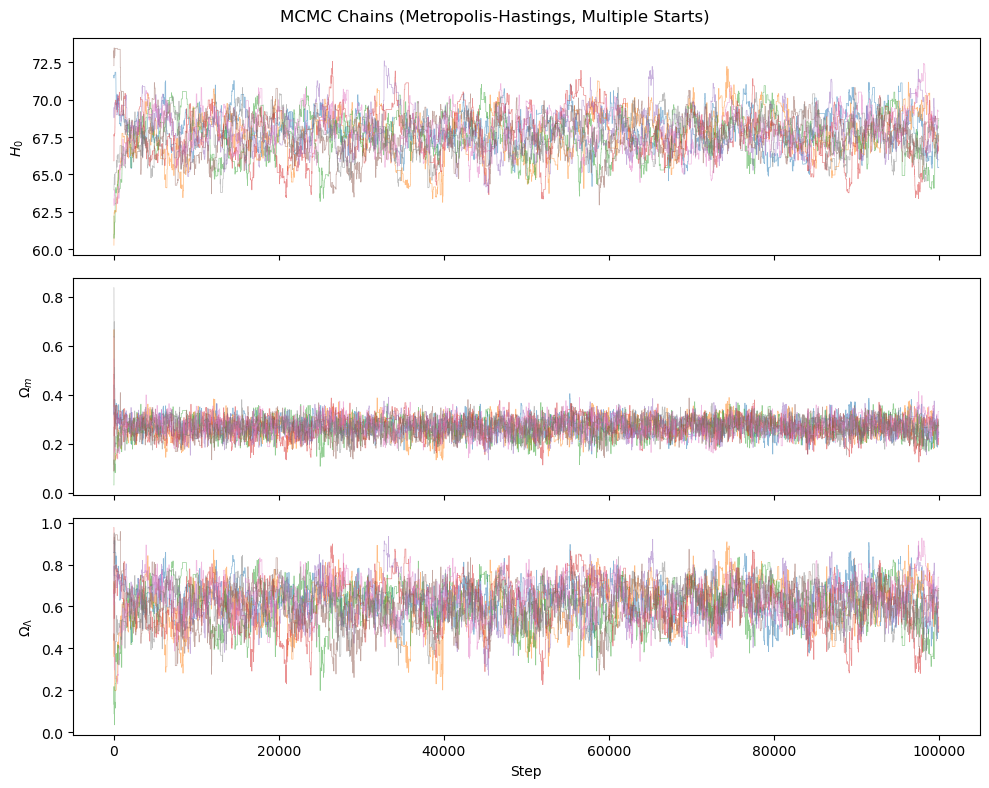

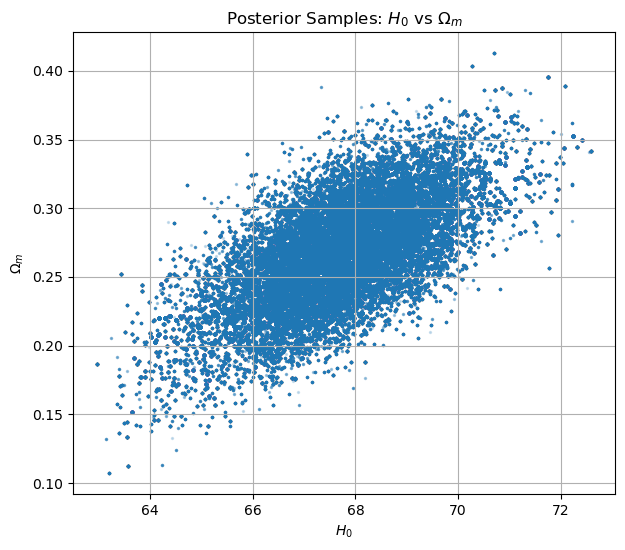

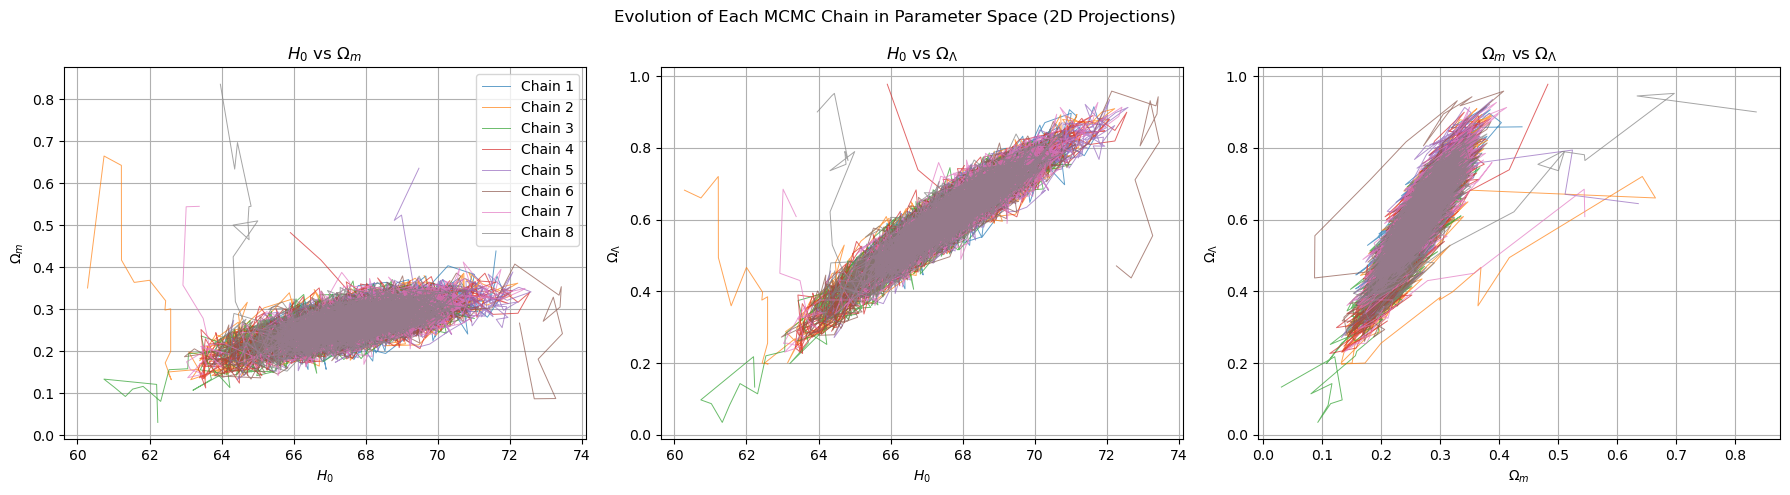

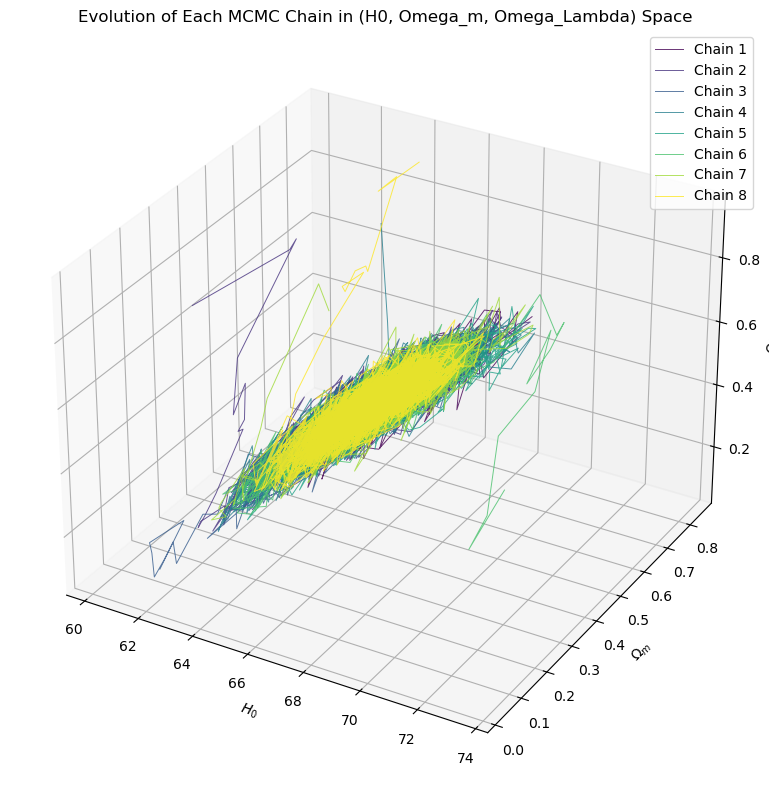

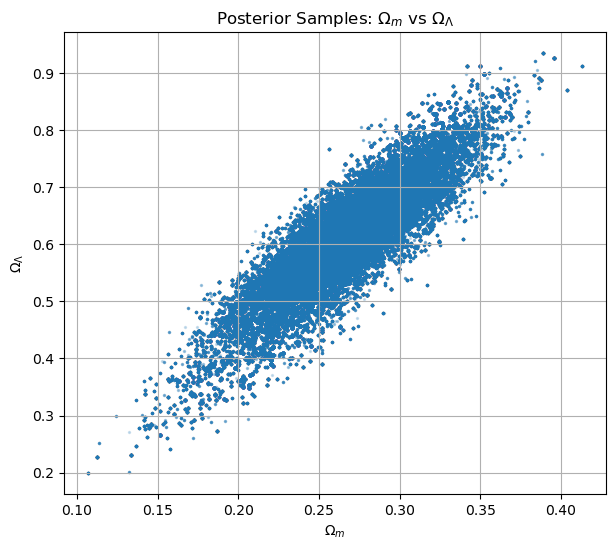

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
for j in range(3):
    for c in range(nMH):
        axes[j].plot(chains[c, :, j], alpha=0.5, lw=0.5)
    axes[j].set_ylabel(labels[j])
axes[2].set_xlabel("Step")
plt.suptitle("MCMC Chains (Metropolis-Hastings, Multiple Starts)")
plt.tight_layout()
plt.show()

# Posterior scatter plots
plt.figure(figsize=(7, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.2, label=r"$H_0$ vs $\Omega_m$")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_m$")
plt.title("Posterior Samples: $H_0$ vs $\Omega_m$")
plt.grid(True)
plt.show()

# Chains evolution in parameter space        
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
pairs = [(0, 1), (0, 2), (1, 2)]
pair_labels = [(labels[0], labels[1]), (labels[0], labels[2]), (labels[1], labels[2])]
for idx, (i, j) in enumerate(pairs):
    for c in range(nMH):
        axes[idx].plot(chains[c, :, i], chains[c, :, j], alpha=0.7, lw=0.7, label=f'Chain {c+1}' if idx==0 else None)
    axes[idx].set_xlabel(pair_labels[idx][0])
    axes[idx].set_ylabel(pair_labels[idx][1])
    axes[idx].set_title(f"{pair_labels[idx][0]} vs {pair_labels[idx][1]}")
    axes[idx].grid(True)
if nMH <= 10:
    axes[0].legend()
plt.suptitle("Evolution of Each MCMC Chain in Parameter Space (2D Projections)")
plt.tight_layout()
plt.show()

# 3D plot: (H0, Omega_m, Omega_Lambda)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, nMH))
for c in range(nMH):
    ax.plot(chains[c, :, 0], chains[c, :, 1], chains[c, :, 2], color=colors[c], alpha=0.8, lw=0.7, label=f'Chain {c+1}')
ax.set_xlabel(r"$H_0$")
ax.set_ylabel(r"$\Omega_m$")
ax.set_zlabel(r"$\Omega_\Lambda$")
ax.set_title("Evolution of Each MCMC Chain in (H0, Omega_m, Omega_Lambda) Space")
if nMH <= 10:
    ax.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.scatter(samples[:, 1], samples[:, 2], s=2, alpha=0.2, label=r"$\Omega_m$ vs $\Omega_\Lambda$")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\Lambda$")
plt.title("Posterior Samples: $\Omega_m$ vs $\Omega_\Lambda$")
plt.grid(True)
plt.show()

## Convergence Diagnostics: Gelman-Rubin $\hat{R}$ and ESS

In [15]:
def gelman_rubin_multi(chains):
    # chains: (nMH, nsteps, ndim)
    nMH, nsteps, ndim = chains.shape
    Rhat = np.zeros(ndim)
    for k in range(ndim):
        chain_k = chains[:, burnin:, k]
        mean_per_chain = np.mean(chain_k, axis=1)
        var_per_chain = np.var(chain_k, axis=1, ddof=1)
        B = nsteps * np.var(mean_per_chain, ddof=1)
        W = np.mean(var_per_chain)
        var_hat = (1 - 1/nsteps) * W + B / nsteps
        Rhat[k] = np.sqrt(var_hat / W)
    return Rhat

Rhat = gelman_rubin_multi(chains)
param_labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
for i, r in enumerate(Rhat):
    print(f"R-hat for {param_labels[i]}: {r:.4f} {'(converged)' if r < 1.01 else '(NOT converged)'}") 
    #I'm conservative with so I use R < 1.01 for convergence

def autocorr_time(chain, max_lag=100):
    n, ndim = chain.shape
    act = np.empty(ndim)
    for k in range(ndim):
        x = chain[:, k] - np.mean(chain[:, k])
        acf = np.correlate(x, x, mode='full')[n-1:] / np.arange(n, 0, -1)
        acf /= acf[0]
        positive = acf[:max_lag][acf[:max_lag] > 0]
        act[k] = 1 + 2 * np.sum(positive[1:])
    return act

tau = autocorr_time(samples)
ESS = samples.shape[0] / tau
for i, ess in enumerate(ESS):
    print(f"ESS for {param_labels[i]}: {ess:.1f}")

R-hat for $H_0$: 1.0099 (converged)
R-hat for $\Omega_m$: 1.0036 (converged)
R-hat for $\Omega_\Lambda$: 1.0079 (converged)
ESS for $H_0$: 3224.1
ESS for $\Omega_m$: 4462.3
ESS for $\Omega_\Lambda$: 3415.5


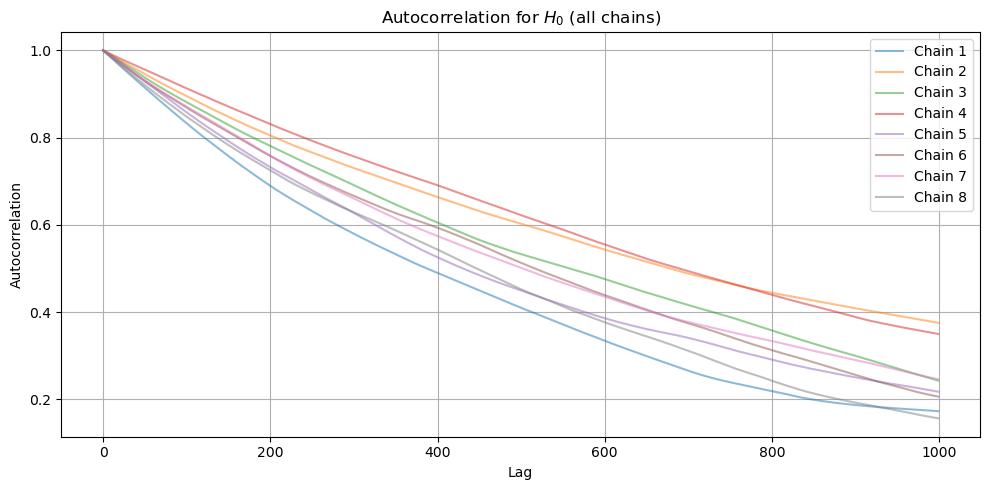

/tmp/ipykernel_21897/2615044510.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


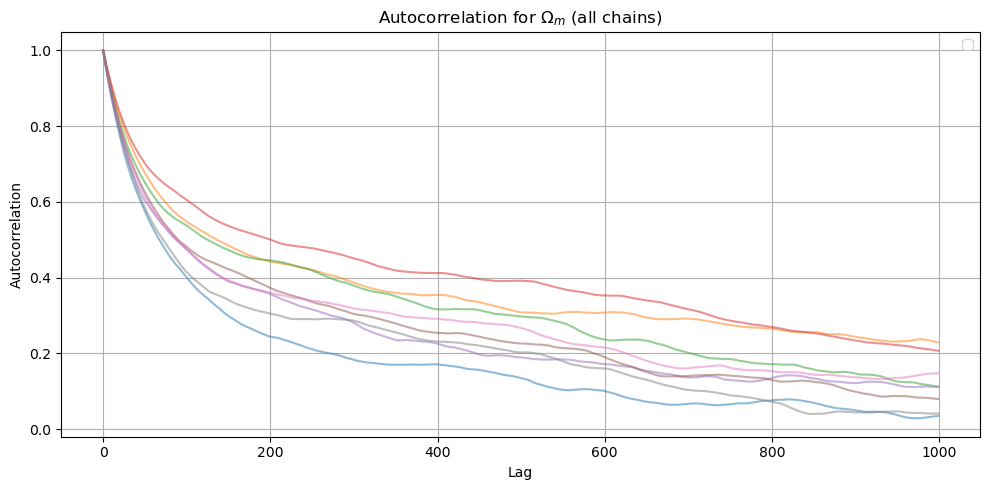

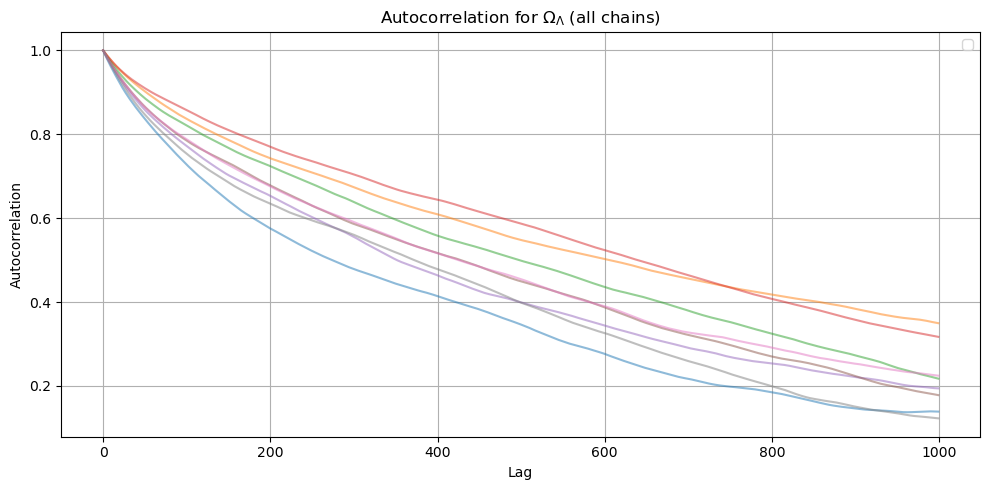

In [16]:
# Plot autocorrelation function for each parameter and each chain
def plot_all_chains_autocorrelation(chains, max_lag=1000):
    import matplotlib.pyplot as plt
    nMH, nsteps, ndim = chains.shape
    labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"]
    for k in range(ndim):
        plt.figure(figsize=(10, 5))
        for c in range(nMH):
            x = chains[c, :, k] - np.mean(chains[c, :, k])
            acf = np.correlate(x, x, mode='full')[nsteps-1:nsteps+max_lag] / np.arange(nsteps, nsteps-max_lag-1, -1)
            acf /= acf[0]
            plt.plot(np.arange(max_lag), acf[:max_lag], alpha=0.5, label=f'Chain {c+1}' if k==0 else None)
        plt.title(f"Autocorrelation for {labels[k]} (all chains)")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.grid(True)
        if nMH <= 10:
            plt.legend()
        plt.tight_layout()
        plt.show()

# Call the function to plot autocorrelation for all chains and parameters
plot_all_chains_autocorrelation(chains, max_lag=1000)

## Literature Comparison and Summary

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, non-flat ΛCDM, DESI+CMB fit</b>
</div>

| ΛCDM              | This work (MCMC, mean ± std) | Paper |
|-------------------|------------------------------|----------------------------|
| $H_0$             | (auto-filled above)          | $68.50 \pm 0.33$ km/s/Mpc |
| $\Omega_m$        | (auto-filled above)          | $0.3034 \pm 0.0037$       |
| $\Omega_\Lambda$  | (auto-filled above)          | $0.6943 \pm 0.0040$       |

All uncertainties are 1 $\sigma$ (standard deviation of the posterior).